**Предобработка датасета**

In [ ]:
#старый код, который использовался для предобработки датасета,
#предобрабатывался датасет, предварительно склеенный из кусочков датасетов, расположенных на сайте хататона и скинутых нам в discord
import pandas as pd
from datetime import datetime

def str_to_datetime_not_hour(a: str): # перевод из строкового формата в формат даты
  return datetime.strptime(a, "%Y-%m-%d")

def is_task_code(a: str): # проверка значения в ячейке 'Кодзадачи'
  for el in a:
    if not el.isdigit() and el != '.':
      return False
  return True

def is_date(aa: str): # приведение всех дат к единому формату, очистка "мусора"
  a = str(aa)
  a = a[:10]
  b = a.split('-')
  if len(b) != 3 or len(b[0]) != 4 or len(b[1]) != 2 or len(b[2]) != 2:
    return float('nan')
  return a

df = pd.read_csv('путь_до_старого_датасета')

#заполняем NaN все ячейки, где встретился мусор

df['Статуспоэкспертизе'] = df['Статуспоэкспертизе'].fillna(0)
df['Экспертиза'] = df['Экспертиза'].fillna('0')
df['Экспертиза'] = df['Экспертиза'].apply(lambda x: x if str(x) in ['0', '1ТС', '2ТС', '1Т', '1С', '2С', '2Т'] else float('nan'))
df['obj_prg'] = df['obj_prg'].apply(lambda x: x if str(x) in ['Образование', 'Здравоохранение'] else 'NaN')
df['obj_subprg'] = df['obj_subprg'].apply(lambda x: x if str(x) in ['Общеобразовательные учреждения', 'Дошкольные учреждения', 'ССК', 'Поликлиники'] else float('nan'))
df['obj_key'] = df['obj_key'].apply(lambda x: x if str(x) in ['019-0594', '019-0431', '019-0676', '020-0711', '020-0157',
       '020-0709', '019-0429', '020-0156', '019-0428', '022-0170',
       '019-0430', '020-0720', '020-0708', '020-0683', '017-0527',
       '020-0155', '021-0048', '022-0176', '022-0354', '019-0675',
       '021-0781', '020-0710', '019-0674', '022-0522', '022-0527',
       '022-0526', '022-0355', '022-0524', '020-0684', '019-0589',
       '021-0550', '017-0520', '022-0171', '020-0776', '020-0149',
       '020-0712', '020-0719', '020-0779', '019-0478', '019-0483',
       '019-0481', '019-0480', '019-0477', '022-0172', '022-0592',
       '019-0469', '019-0475', '019-0464', '019-0471', '019-0467',
       '019-0474', '019-0463', '019-0472', '019-0470', '019-0473',
       '019-0465', '019-0466', '019-0668', '020-0151', '022-0518',
       '022-0043', '022-0629', '019-0476', '021-0548', '022-0519', '022-0520',
       '022-0631', '022-0513', '022-0626', '022-0515'] else float('nan'))
df['Кодзадачи'] = df['Кодзадачи'].apply(lambda x: x if is_task_code(str(x)) else float('nan'))

#удаляем ненужные столбцы
df = df.drop(columns = ['Unnamed: 0', '№ п/п'], axis = 1)


#удаляем строчки, где встречаются NaN
df['ДатаНачалаЗадачи'] = df['ДатаНачалаЗадачи'].apply(is_date)
df['ДатаОкончанияЗадачи'] = df['ДатаОкончанияЗадачи'].apply(is_date)
df['ДатаначалаБП0'] = df['ДатаначалаБП0'].apply(is_date)
df['ДатаокончанияБП0'] = df['ДатаокончанияБП0'].apply(is_date)
df['date_report'] = df['date_report'].apply(is_date)
df = df.dropna(subset=['ДатаначалаБП0', 'ДатаокончанияБП0', 'Экспертиза','obj_prg', 'obj_subprg', 'obj_key', 'Кодзадачи', 'ДатаНачалаЗадачи', 'ДатаОкончанияЗадачи'])
df.reset_index(drop = True , inplace = True )

#добавляем в датафрейм стоблец с площадью объекта
df2 = pd.read_csv('drive/MyDrive/attr.csv', low_memory=False)
area = []
for el in df.obj_key:
  area.append(df2[df2['obj_key'] == el]['Площадь'].mean())
df['area'] = area
df['area'] = df.area.fillna(df['area'].mean())


#добавляем целевой столбец - сдвиг срока
start = df['ДатаокончанияБП0']
end = df['ДатаОкончанияЗадачи']

itog = []
for i in range(len(end)):

    a = str_to_datetime_not_hour(end[i])
    b = str_to_datetime_not_hour(start[i])
    razn = a - b
    itog.append(razn)

df['delta'] = itog

#добавляем столбцы со временем года, когда начиналась работа над задачей
date = df['ДатаНачалаЗадачи']

season = []

for i in range(len(date)):
    a = date[i]
    pred = a[5:7]
    if pred in ['01', '02', '12']:
        season.append('Зима')
    elif pred in ['03', '04', '05']:
        season.append('Весна')
    elif pred in ['06', '07', '08']:
        season.append('Лето')
    else:
        season.append('Осень')

df['ВремяГодаНачала'] = season

date = df['ДатаокончанияБП0']

season = []

for i in range(len(date)):
    a = date[i]
    pred = a[5:7]
    if pred in ['01', '02', '12']:
        season.append('Зима')
    elif pred in ['03', '04', '05']:
        season.append('Весна')
    elif pred in ['06', '07', '08']:
        season.append('Лето')
    else:
        season.append('Осень')

df['ВремяГодаОкончанияБП0'] = season

# Датасет

Датасет предварительно *отбработан*: избавились от *опечаток*, поработали с *NaN*'ами и *выбросами*, добавили новые **фичи** (время года на начало строительства, время года на окончание строительства по плану, площадь (спарсили из attr.csv), delta - таргет, отклонение от плана в днях (положительное - для запаздывания, отрицательное - для выполнения заранее), обработали столбцы "*Статуспоэкспертизе*" и "*Экспертиза*").

In [ ]:
df = pd.read_csv('DigitalBreakthroughDataset.csv', low_memory=False).drop("Unnamed: 0", axis=1)
df

,obj_prg,obj_subprg,obj_key,Кодзадачи,НазваниеЗадачи,ПроцентЗавершенияЗадачи,ДатаНачалаЗадачи,ДатаОкончанияЗадачи,ДатаначалаБП0,ДатаокончанияБП0,Статуспоэкспертизе,Экспертиза,ВремяГодаНачала,ВремяГодаОкончанияБП0,delta,area
0,Образование,Общеобразовательные учреждения,019-0594,1,Предпроектные работы,0.0,2021-05-04,2021-12-15,2021-05-04,2021-12-15,0.0,0,Весна,Зима,0,17488.00
1,Образование,Общеобразовательные учреждения,019-0431,1,Предпроектные работы,100.0,2020-11-02,2021-07-26,2020-11-02,2021-07-26,0.0,0,Осень,Лето,0,19433.40
2,Образование,Общеобразовательные учреждения,019-0676,1,Предпроектные работы,100.0,2021-02-01,2022-09-15,2021-02-01,2022-07-31,0.0,0,Зима,Лето,46,6291.00
3,Образование,Общеобразовательные учреждения,020-0711,1,Предпроектные работы,100.0,2021-05-12,2021-12-30,2021-05-12,2022-05-12,0.0,0,Весна,Весна,-133,7265.00
4,Образование,Общеобразовательные учреждения,020-0157,1,Предпроектные работы,100.0,2020-10-30,2022-10-24,2020-10-30,2021-09-30,0.0,0,Осень,Осень,389,7243.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1104002,Образование,Общеобразовательные учреждения,020-0720,9.6.2,КC-11 оформлена (АКТ приёмки завершенного стро...,0.0,2023-09-11,2023-09-11,2023-09-11,2023-09-11,0.0,0,Осень,Осень,0,20164.69
1104003,Образование,Общеобразовательные учреждения,022-0522,9.6.2,КC-11 оформлена (АКТ приёмки завершенного стро...,0.0,2025-08-11,2025-08-11,2025-08-11,2025-08-11,0.0,0,Лето,Лето,0,13260.00
1104004,Образование,Общеобразовательные учреждения,022-0527,9.6.2,КC-11 оформлена (АКТ приёмки завершенного стро...,0.0,2024-08-21,2024-08-21,2024-08-07,2024-08-07,0.0,0,Лето,Лето,14,9850.00
1104005,Образование,Общеобразовательные учреждения,022-0526,9.6.2,КC-11 оформлена,0.0,2025-08-11,2025-08-11,2025-08-11,2025-08-11,0.0,0,Лето,Лето,0,18100.00


Удалим столбцы с *датами* - их сложно обрабатывать и в итоге они приводят к *переобучению*.

In [ ]:
df = df.drop(['ДатаНачалаЗадачи', 'ДатаОкончанияЗадачи', 'ДатаначалаБП0', 'ДатаокончанияБП0'], axis=1)

array([[<Axes: title={'center': 'ПроцентЗавершенияЗадачи'}>]],
      dtype=object)

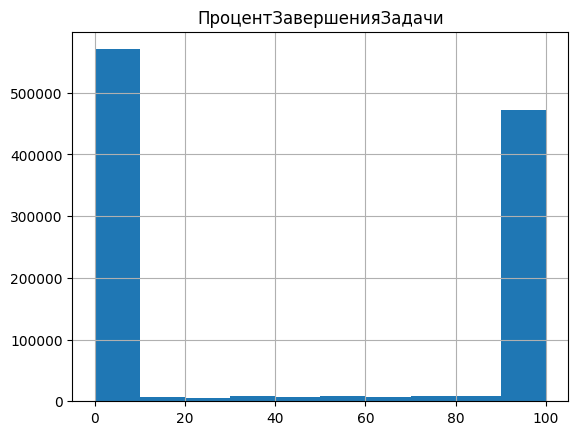

In [ ]:
df.hist('ПроцентЗавершенияЗадачи')

В чате хакатона замечали, что можно обучаться только на данных с процентом завершения задачи 100.

In [ ]:
df = df[df['ПроцентЗавершенияЗадачи'] == 100]

# Графики

Рассмотрим попарные корреляции целевого столбца с остальными:


<ipython-input-6-49e0a93c0524>:8: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(pd.DataFrame(df.drop('ПроцентЗавершенияЗадачи', axis=1).corrwith(df['delta']).sort_values(


<Axes: >

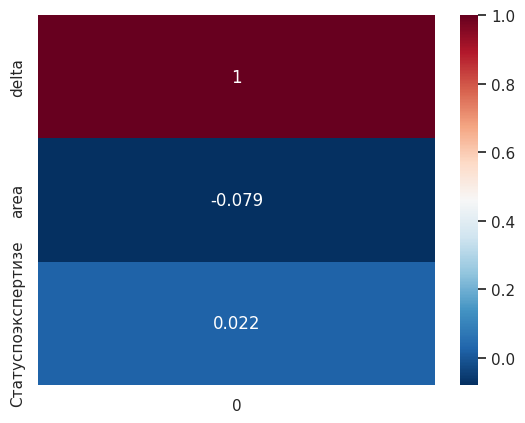

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set()
plt.figure()

sns.heatmap(pd.DataFrame(df.drop('ПроцентЗавершенияЗадачи', axis=1).corrwith(df['delta']).sort_values(
    key=lambda x: abs(x), ascending=False)), annot=True,
    cmap=sns.color_palette("RdBu_r", 1000))

Рассмотрим также коэффиценты корреляции Спирмена:

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


<Figure size 1000x1000 with 0 Axes>

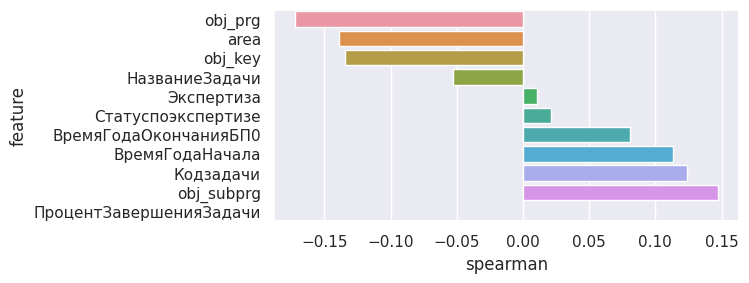

In [ ]:
sns.set(font_scale=1)
plt.figure(figsize=(10, 10))


def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['delta'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')


features = df.columns.drop(['delta'])
spearman(df, features)

# Градиентый бустинг

Создадим список **категориальных признаков**.

In [ ]:
cat_features = ['obj_prg', 'obj_subprg', 'obj_key', 'Кодзадачи', 'НазваниеЗадачи', 'Экспертиза', 'ВремяГодаНачала', 'ВремяГодаОкончанияБП0']

Разобьем датасет на train  и test для обучения.

In [ ]:
from sklearn.model_selection import train_test_split


X = df.drop(['delta'], axis = 1)
y = df['delta']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


Переходим к обучению. Использовался *градиентный бустинг* в реализиции библиотеки *Яндекса* **Catboost**. Обратим внимание на то, что деревья уже сами по себе имеют **глубину 12** и обладают большей обобщающей способностью.

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.2 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor, Pool


eval_pool = Pool(X_test, y_test, cat_features=cat_features)
model = CatBoostRegressor(cat_features=cat_features, learning_rate=0.5,
                          depth=12, iterations=500, eval_metric="MAE",
                          custom_metric="MAE", loss_function='MAE')

model.fit(X_train, y_train, early_stopping_rounds=50, eval_set=eval_pool)   # используем встроенную защиту от переобучения

0:	learn: 43.4577962	test: 43.2610483	best: 43.2610483 (0)	total: 1.56s	remaining: 13m 1s
1:	learn: 37.6148571	test: 37.2427640	best: 37.2427640 (1)	total: 3.98s	remaining: 16m 31s
2:	learn: 34.4812773	test: 33.9615463	best: 33.9615463 (2)	total: 6.55s	remaining: 18m 4s
3:	learn: 33.2572267	test: 32.6783325	best: 32.6783325 (3)	total: 7.94s	remaining: 16m 24s
4:	learn: 32.2993472	test: 31.6493535	best: 31.6493535 (4)	total: 9.32s	remaining: 15m 22s
5:	learn: 31.0110377	test: 30.3019078	best: 30.3019078 (5)	total: 10.9s	remaining: 14m 53s
6:	learn: 30.3931601	test: 29.5594650	best: 29.5594650 (6)	total: 12s	remaining: 14m 3s
7:	learn: 30.1940154	test: 29.3194630	best: 29.3194630 (7)	total: 13.1s	remaining: 13m 26s
8:	learn: 29.7037394	test: 28.8017471	best: 28.8017471 (8)	total: 14.5s	remaining: 13m 10s
9:	learn: 29.4843791	test: 28.6081394	best: 28.6081394 (9)	total: 15.5s	remaining: 12m 41s
10:	learn: 29.2975462	test: 28.4259635	best: 28.4259635 (10)	total: 17.5s	remaining: 12m 59s
11

Вычислим **MAE**.

In [ ]:
from sklearn.metrics import mean_absolute_error

preds = model.predict(X_test)
mean_absolute_error(preds, y_test)


11.755280369754479

Выгружаем модель в формате **CBM**.

In [ ]:
model.save_model("model.cbm")